In [1]:
import numpy as np
import theano
import theano.tensor as tt
import pymc3 as pm
import datetime
import pandas as pd

import time
import pickle

import matplotlib.pyplot as plt
import matplotlib
theano.config.optimizer='fast_run'
theano.config.floatX = "float64"

# Legend-formating for matplotlib
def _format_k(prec):
    """
        format yaxis 10_000 as 10 k.
        _format_k(0)(1200, 1000.0) gives "1 k"
        _format_k(1)(1200, 1000.0) gives "1.2 k"
    """

    def inner(xval, tickpos):
        return f"${xval/1_000:.{prec}f}\,$k"

    return inner


In [2]:
def plain_SIR_model(beta,gamma,N,S0,I0,R0,l=150):
    """Simple classical SIR-Model with time-constant beta,gamma"""
    def next_day(t,St,It,Rt,oS,oI,oR,eff,beta,gamma,N):
        eff = beta*St/N
        bSIoN = eff * It # -beta * (S*I)/N
        gI = gamma*It
        # Calculate differences
        dS = -bSIoN
        dI = bSIoN - gI
        dR = gI
        # Update values
        nxt_St = St + dS
        nxt_It = It + dI
        nxt_Rt = Rt + dR
        
        nxt_St = tt.clip(nxt_St,0,1e16) # Improves sampling stability
        
        # Pass on to next step
        return nxt_St,nxt_It,nxt_Rt, dS,dI,dR, eff
        
    # Initial internal state
    zero = tt.cast(0.,dtype='float64')
    initial_state = [S0,I0,R0,zero,zero,zero,zero]
    sequences = [tt.arange(l)]
    # Exceute the 'Loop'
    state,_ = theano.scan(fn=next_day,
                            sequences=sequences,# time dependent sequences can be passed as first params
                            outputs_info=initial_state,
                            non_sequences=[beta,gamma,N])
    return state


def Gompertz(a,b,c,l=150):
    t = tt.arange(l)
    return a*tt.exp(-b*tt.exp(-c*t))

In [23]:
# Data from
#https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv
#Germany,51.165690999999995,10.451526,
jhu_deaths = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3,3,7,9,11,17,24,28,44,67,84,94,123,157,206,267,342,433,533,645,775,920,1107,1275,1444,1584,1810,2016,2349,2607,2767,2736,3022,3194,3294,3804,4052,4352,4459,4586,4862,5033,5279,5575,5760,5877,5976,6126,6314,6467,6623,6736,6812,6866,6993,6993,7275,7392,7510,7549,7569,7661,7738,7861,7884,7897,7938,7962,8003,8081,8144,8203,8228,8261,8283,8309,8372,8428,8470,8504,8530,8540,8555,8563,8602,8635,8658,8673,8685,8695,8736,8752,8772,8783,8793,8801,8807,8820,8851,8875,8887,8895,8895,8899,8914,8928,8940,8965,8968,8968,8976,8990,8995,9006,9010,9020,9023,9022,9032,9046,9057,9063,9070,9071,9074,9078,9080,9087,9088,9091,9092,9094,9099,9102,9110,9120,9124,9124,9125,9131,9135,9144,9147,9154,9154,9154,9163,9179,9181,9195,9201,9202,9203,9208,9213,9217,9230,9235,9235,9236,9241,9249,9263,9266,9272,9275,9276,9281,9285,9290,9290,9299]
jhu_ts = pd.date_range(datetime.date(2020,1,21),periods=len(jhu_deaths),freq='D')

# Limit to non-zero values, dropping the front of the list
first_non_zero_index = 47
jhu_deaths1 = jhu_deaths[first_non_zero_index:]
jhu_ts1 = jhu_ts[first_non_zero_index:]
print("first non zero deaths timestamp",jhu_ts1[0])

# Alternative Deaths from Situation-report graph of actual dates of deaths
rki_deaths_per_day = [1, 1, 1, 1, 5, 2, 3, 4, 11, 13, 12, 21, 40, 24, 42, 42, 67, 76, 92, 104, 107, 114, 172, 165, 162, 204, 199, 223, 240, 240, 254, 260, 257, 240, 246, 239, 243, 245, 227, 239, 241, 191, 203, 209, 172, 194, 157, 163, 129, 141, 132, 125, 128, 121, 106, 76, 92, 78, 93, 82, 69, 54, 63, 64, 63, 42, 54, 66, 47, 29, 40, 44, 45, 47, 31, 33, 27, 30, 31, 23, 21, 18, 19, 17, 18, 24, 15, 18, 18, 14, 8, 9, 8, 6, 11, 11, 14, 9, 6, 9, 7, 7, 9, 6, 3, 4, 4, 6, 7, 7, 7, 4, 7, 8, 1]
rki_deaths = np.cumsum(rki_deaths_per_day)
rki_ts = pd.date_range(datetime.date(2020,3,8),periods=len(rki_deaths),freq='D')

sources = {"jhu":(jhu_deaths,jhu_ts),"jhu1":(jhu_deaths1,jhu_ts1),"rki":(rki_deaths,rki_ts)}

data,ts = sources["jhu1"]

#t_lables = []

first non zero deaths timestamp 2020-03-08 00:00:00


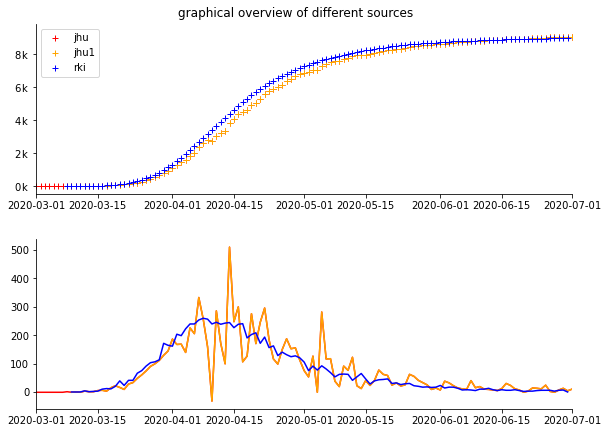

In [8]:
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(wspace=0.33,hspace=0.27,left=0.05,right=0.98,top=0.94,bottom=0.05)
fig.suptitle("graphical overview of different sources")
gs = fig.add_gridspec(2, 1)

ax = fig.add_subplot(gs[0,0])
bx = fig.add_subplot(gs[1,0])

i = 0
color=["red","orange","blue"]
for k,v in sources.items():
   
    d,t = v
    ax.plot(t,d,'+',label=k,color=color[i])
    bx.plot(t[1:],np.diff(d),label=k,color=color[i])
    i+=1
    
ax.set_xlim([datetime.date(2020,3,1),datetime.date(2020,7,1)])
bx.set_xlim([datetime.date(2020,3,1),datetime.date(2020,7,1)])
ax.legend()
    
for tx in [ax,bx]:
    prec = 1.0 / (np.log10(tx.get_ylim()[1]) - 2.5)
    if prec < 2.0 and prec >= 0:
        tx.yaxis.set_major_formatter(
            matplotlib.ticker.FuncFormatter(_format_k(int(prec)))
        )
    tx.spines['top'].set_visible(False)
    tx.spines['right'].set_visible(False)
        

In [11]:
# Test simple SIR-Fit beta,gamma,N,I0

def FitSIRModel(data,l=90,initial={},fit_I0=True,fit_differences=False):
    """
    Fit SIR model using HamiltonianMonteCarlo No-UTurn-Sampler 
        fit_0 : Allow fitting I0 else I0 = 1
        fit_differences : False # keep it that way until daily differences are of interest and not total numbers
    """
    with pm.Model() as model:
        # Setup Priors for beta,gamma
        beta = pm.Lognormal(name="beta",
                        mu=tt.log(tt.cast(.4,dtype='float64')),
                        sigma=tt.cast(.4,dtype='float64')) # Choose both beta and gamma wide enough
        gamma = pm.Lognormal(name="gamma",
                         mu=tt.log(tt.cast(.13,dtype='float64')),
                         sigma=tt.cast(.3,dtype='float64'))
        beta = tt.clip(beta,gamma,1e3) # Ensure positive initial growth, improves sampling
    
#        N = tt.cast(83e6,dtype='float64')
        N = pm.Lognormal(name="N",mu=tt.log(tt.cast(10000,dtype='float64')),sigma=tt.cast(.95,dtype='float64'))
        S0 = N
        if fit_I0: # Eiher fit or don't fit I0
            I0 = pm.Lognormal(name="I0",
                      mu=tt.log(tt.cast(1.,dtype='float64')),
                      sigma=tt.cast(.5,dtype="float64")
                     )
        else:
            I0 = tt.cast(1,dtype='float64')
    
        R0 = tt.cast(0.,dtype='float64')
    
        # Run the Model
        S_t,I_t,R_t,dS,dI,dR,eff = plain_SIR_model(beta,gamma,N,S0,I0,R0,l=l)
        # Store Model output in Trace
        pm.Deterministic("S_t",S_t)
        pm.Deterministic("I_t",I_t)
        pm.Deterministic("R_t",R_t)
        pm.Deterministic("dR",dR)
        pm.Deterministic("dS",dS)
        
        # Loglike-estimate
        if fit_differences: # Fit differences, which might me more suitable for the Sampler
            est_deaths = dR
            sigma_obs = pm.HalfCauchy( name="sigma", beta=10 )
            pm.StudentT(
                    name="like_studentT",
                    nu=4,
                    mu=est_deaths,
                    sigma=tt.abs_(est_deaths + 1) ** 0.5 * sigma_obs,
                    observed=np.diff(deaths1[:l+1])
            )
        else: # Leads to tighter fit to the non-differentiated data
            est_deaths = R_t
            sigma_obs = pm.HalfCauchy( name="sigma", beta=50 )
            pm.StudentT(
                    name="like_studentT",
                    nu=4,
                    mu=est_deaths,
                    sigma=tt.abs_(est_deaths + 1) ** 0.5 * sigma_obs,
                    observed=data[:l]
            )
        
        # Handle Chained sampling reusing previous fit as starting-point
        init = "advi+adapt_diag" if len(initial) == 0 else None
        trace = pm.sample( model=model,init=init,start=initial,draws=1200,tune=1200,cores=4,chains=4)#,max_treedepth=16)
        return trace

In [17]:
def SIRSeries(data,start=30,end=120,fit_I0=True):
    estimates = {}
    tr = None
    for l in range(start,end+1):
        initial = {} if tr == None else {'beta':np.mean(tr.beta),'gamma':np.mean(tr.gamma),'N':np.mean(tr.N)}
        if fit_I0 and tr != None:
            initial['I0'] = np.mean(tr.I0)
            
        tr = FitSIRModel(data=data,l=l,initial=initial,fit_I0=fit_I0)
        ssd = np.sum(np.power(data[:l]-np.mean(tr.R_t,axis=0),2))
        estimates[l] = {'beta':tr.beta,'gamma':tr.gamma,'N':tr.N,"ssd":ssd}
        if fit_I0:
            estimates[l]["I0"] = tr.I0
    return estimates

sir_est = SIRSeries(data,30,90)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 18900
Interrupted at 18,899 [9%]: Average Loss = 198.41
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 365 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 358 seconds.
The acceptance probability does not match the target. It is 0.6755138536843613, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5763221292618249, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 426 seconds.
The acceptance probability does not match the target. It is 0.7044214145095171, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 312 seconds.
The acceptance probability does not match the target. It is 0.6624247049133449, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 292 seconds.
The acceptance probability does not match the target. It is 0.6661113809822419, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 304 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 251 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 272 seconds.
The acceptance probability does not match the target. It is 0.586806815747669, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 265 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 244 seconds.
The acceptance probability does not match the target. It is 0.7197333768875086, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 236 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 205 seconds.
The acceptance probability does not match the target. It is 0.6965473458160671, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 207 seconds.
The acceptance probability does not match the target. It is 0.6703440683890286, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.883791711653083, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 184 seconds.
The acceptance probability does not match the target. It is 0.7128080913996852, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 180 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 196 seconds.
The acceptance probability does not match the target. It is 0.6035834771810903, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5402765044624211, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 182 seconds.
The acceptance probability does not match the target. It is 0.7089954426621434, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 197 seconds.
The acceptance probability does not match the target. It is 0.6533089082536224, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 184 seconds.
The acceptance probability does not match the target. It is 0.3622113532068885, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6927185658012439, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 213 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.39952670729845263, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.20385697518601578, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 256 seconds.
The acceptance probability does not match the target. It is 0.7199395222130034, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6941624037629094, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 250 seconds.
The acceptance probability does not match the target. It is 0.6915373212776679, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 289 seconds.
The acceptance probability does not match the target. It is 0.22317803001801834, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 292 seconds.
The acceptance probability does not match the target. It is 0.5859447408424182, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5834978657167031, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.49525417629800006, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 342 seconds.
The acceptance probability does not match the target. It is 0.7038875088280391, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 341 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 350 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 314 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 328 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 319 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 319 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 318 seconds.
The acceptance probability does not match the target. It is 0.6337843558929364, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 311 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 302 seconds.
The acceptance probability does not match the target. It is 0.7000125506401269, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 298 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 299 seconds.
The acceptance probability does not match the target. It is 0.8791844018994647, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 292 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 286 seconds.
The acceptance probability does not match the target. It is 0.8882526972971975, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 272 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 286 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 268 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 266 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 247 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 246 seconds.
The acceptance probability does not match the target. It is 0.879435374833032, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 244 seconds.
The acceptance probability does not match the target. It is 0.8897653343264543, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 251 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 242 seconds.
The acceptance probability does not match the target. It is 0.8862149260968081, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 247 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 263 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 236 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 249 seconds.
The acceptance probability does not match the target. It is 0.7180635421651097, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 238 seconds.
The acceptance probability does not match the target. It is 0.8872722441734407, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 242 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 254 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 241 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 244 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 244 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 262 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 273 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 281 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, I0, N, gamma, beta]


Sampling 4 chains for 1_200 tune and 1_200 draw iterations (4_800 + 4_800 draws total) took 268 seconds.


In [20]:
with open("estimates/sir_%d"%time.time(),"wb+") as f:
    pickle.dump(sir_est,f)

for k,v in sir_est.items():
    print(k,v["ssd"])
    for p in ['beta','gamma','N','I0']:
        print("\t",p,np.mean(v[p]),np.percentile(v[p],q=(2.5,5,50,95,97.5)))

30 5193.81726622813
	 beta 0.46485777774498804 [0.40776575 0.4163104  0.4623652  0.52049683 0.53258734]
	 gamma 0.1577138463939369 [0.09745357 0.10562928 0.15466592 0.21671906 0.231231  ]
	 N 3675.783610837497 [3337.31140446 3395.79457221 3644.03097329 4053.35282247 4176.20160668]
	 I0 4.857878836855406 [3.27997895 3.419956   4.73166828 6.74798752 7.37504822]
31 45492.52227784255
	 beta 0.4666564181997164 [0.40529548 0.4120172  0.46698607 0.51798956 0.51997082]
	 gamma 0.16204787576650378 [0.0964026  0.1044833  0.16129278 0.21706549 0.2189345 ]
	 N 3754.9884870517426 [3399.28855279 3467.59346419 3711.28599679 4169.65652795 4292.27443429]
	 I0 4.872272167216246 [3.47504689 3.53451858 4.62879648 7.04039122 7.53533993]
32 104791.99416125035
	 beta 0.4483094204835156 [0.39790902 0.40522936 0.44663376 0.49842225 0.51121885]
	 gamma 0.14610768001599067 [0.09204615 0.09941369 0.14435767 0.19896471 0.2133237 ]
	 N 3958.0644823696202 [3534.08955059 3590.46017342 3907.72741491 4443.1190371  4576

In [24]:
def FitGompertz(data,l=90,initial={}):
    with pm.Model() as model:
        a = pm.Lognormal(name="a",
                    mu=tt.log(tt.cast(1e5,dtype='float64')),
                    sigma=tt.cast(.6,dtype='float64'))
        b = pm.Lognormal(name="b",
                    mu=tt.log(tt.cast(11,dtype='float64')),
                    sigma=tt.cast(.8,dtype='float64'))
        c = pm.Lognormal(name="c",
                    mu=tt.log(tt.cast(.07,dtype='float64')),
                    sigma=tt.cast(.8,dtype='float64'))
    
        est = Gompertz(a,b,c,l)
        est_deaths = pm.Deterministic("deaths",est)
    
        sigma_obs = pm.HalfCauchy( name="sigma", beta=40 )
        pm.StudentT(
                    name="like_studentT",
                    nu=4,
                    mu=est_deaths,
                    sigma=tt.abs_(est_deaths + 1) ** 0.5 * sigma_obs,
                    observed=data[:l]
        )
        init = "advi+adapt_diag" if len(initial) == 0 else None
        trace = pm.sample( model=model,init=init,start=initial,draws=1200,tune=2000,cores=4,chains=4)
        return trace

In [25]:
def GompertzSeries(data,start=30,end=120):
    estimates = {}
    tr = None
    for l in range(start,end+1):
        initial = {} if tr == None else {'a':np.mean(tr.a),'b':np.mean(tr.b),'c':np.mean(tr.c)}
        tr = FitGompertz(data,l=l,initial=initial)
        ssd = np.sum(np.power(data[:l]-np.mean(tr.deaths,axis=0),2))
        estimates[l] = {'a':tr.a,'b':tr.b,'c':tr.c,"ssd":ssd}
    return estimates

gomp_est = GompertzSeries(data,30,90)


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 10200
Interrupted at 10,199 [5%]: Average Loss = 240.56
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 32 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 29 seconds.
The acceptance probability does not match the target. It is 0.6513892863935599, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 31 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 37 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 30 seconds.
The acceptance probability does not match the target. It is 0.6993694502635149, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 30 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 29 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 24 seconds.
The acceptance probability does not match the target. It is 0.9018182377881787, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.8823588735409186, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 22 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8940654285281037, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.8795598629912535, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 19 seconds.
The acceptance probability does not match the target. It is 0.7105743959647153, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6658747619400627, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.6561844417891206, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
The acceptance probability does not match the target. It is 0.6832717870454563, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 19 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 20 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 19 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 19 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.7059219906321565, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.6853291467403411, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8916032717177821, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 18 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8851322722036938, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8997051852828197, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 18 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.880911065659166, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8806429189029005, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8895138441634785, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.88291534633608, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8964430225528213, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8983374476671028, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8931777999210037, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 18 seconds.
The acceptance probability does not match the target. It is 0.8806832451063462, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 17 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 17 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 17 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8820277953779176, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8838507505791093, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.7201223535360893, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8796236973042904, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.7075853422732856, but should be close to 0.8. Try to increase the number of tuning steps.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 15 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 17 seconds.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, c, b, a]


Sampling 4 chains for 2_000 tune and 1_200 draw iterations (8_000 + 4_800 draws total) took 16 seconds.


In [28]:
with open("estimates/gomp_%d"%time.time(),"wb+") as f:
    pickle.dump(gomp_est,f)

for k,v in gomp_est.items():
    print(k,v["ssd"])
    for p in ['a','b','c']:
        print("\t",p,np.mean(v[p]),np.percentile(v[p],q=(2.5,5,50,95,97.5)))


30 22643.445061460436
	 a 26663.318370430887 [16805.26032899 17788.43550958 25088.03660767 41314.01732856
 45762.67003871]
	 b 10.448181075707762 [10.19605322 10.22667485 10.43514683 10.70585858 10.77702657]
	 c 0.04944142882205788 [0.04336748 0.04434179 0.04952435 0.05434066 0.05528608]
31 18670.75445374735
	 a 23993.631506488793 [17502.53787006 18271.54065483 23165.36963441 32394.05492406
 35519.8036418 ]
	 b 10.39622596254256 [10.19602005 10.22513124 10.39044743 10.59200112 10.63262283]
	 c 0.0502842200174515 [0.04537734 0.04629113 0.0504005  0.05395943 0.05471622]
32 17683.2007130446
	 a 23099.119147282763 [17359.66954273 18055.33363725 22633.07382849 29788.3388814
 31521.49953328]
	 b 10.375654177969906 [10.19022439 10.22017906 10.37033552 10.54814294 10.58174091]
	 c 0.05062875560384602 [0.04629581 0.04698988 0.05062587 0.05420122 0.05504093]
33 29174.162609006402
	 a 20991.021693618226 [15762.01290784 16419.37171799 20595.74227541 26855.15384181
 28346.79259956]
	 b 10.358713441

In [ ]:
trace = FitGompertz(l=30)
plt.plot(ts1[:l],deaths1[:l],"+")
plt.plot(ts1[:l],trace.deaths[0])
plt.fill_between(ts1[:l],*np.percentile(trace.deaths,axis=0,q=(2.5,97.5)),color="orange",alpha=.2)

gomp_est = np.mean(trace.deaths,axis=0)
print(SSD(deaths1[:1],gomp_est))
